##  A simple convolutional neural net for classification of MNIST datasetwith data augmentation and early stopping
A model contains: 
 - batch_norm
 - dropout
 - exponentialy decaying learning rate

In [25]:
import os
import sys
import blosc

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

sys.path.append("..")
from my_batch import MnistBatch
from dataset import DatasetIndex, Dataset
from my_batch import draw_stats, draw_digit

## Load data

Let us load all data at once instead of doing this for every batch because it can all be loaded in memory.

In [4]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 0

src = 'C:\\Users\\Dari\\Documents\\az_training\\task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)
# src = (full_imgs, full_labs)

env: CUDA_VISIBLE_DEVICES=0


### Create dataset:

In [10]:
LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

bch = MnistBatch(indy.create_subset(indy.indices[1:5]))

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
stats = []
lr_history = []

## Train on the original data

In [16]:
# pipeline for train
ppl = (mnistset.train.pipeline().
       load(src=src, fmt='ndarray').
       train_convy(sess))

# pipeline for test
ppl_test = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            update_stats(sess, stats, lr_history))

In [17]:
max_accuracy = 0
window = 50
sum_window = 0
stop_condition = 0.91

for i in tqdm(range(1000)):
    ppl.next_batch(100, n_epochs=None)
    ppl_test.next_batch(100, n_epochs=None)
    if stats[i] > max_accuracy:
        max_accuracy = stats[i]
    if i % 50 == 0:
        cr = sum_window / window * max_accuracy 
        sum_window = sum(stats[i - window + 1: i])
        # do early stopping 
        if cr > stop_condition:
            break

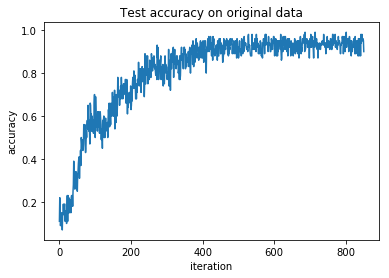

In [18]:
draw_stats(stats, 'Test accuracy on original data')

## Test on augmented data (shifted, rotated, scaled)

In [19]:
ppl_test_shift = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            shift_flattened_pic().
            random_rotate(p=1, angle=(-10, 10), preserve_shape=True).
            random_scale(p=1, factor=(.8, 1.2)).
            update_stats(sess, stats, lr_history))

In [20]:
for i in tqdm(range(400)):
    ppl_test_shift.next_batch(100, n_epochs=None)

Predictably we see that our net badly predicts augmented data

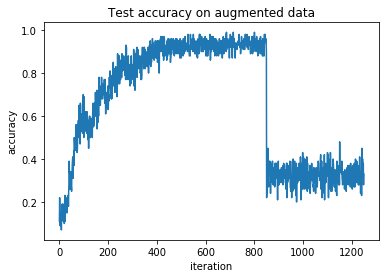

In [21]:
draw_stats(stats, title='Test accuracy on augmented data')

Let's see some examples where the net makes mistakes:

In [22]:
pics = []
y_true = []
y_predict = []
probs = []

ppl_results = (mnistset.test.pipeline().
    load(src=src, fmt='ndarray').
    shift_flattened_pic().
    random_rotate(p=1, angle=(-10, 10), preserve_shape=True).
    random_scale(p=1, factor=(.8, 1.2)).
    predict(sess, pics, y_true, y_predict, probs))

In [23]:
ppl_results.next_batch(100, n_epochs=None)

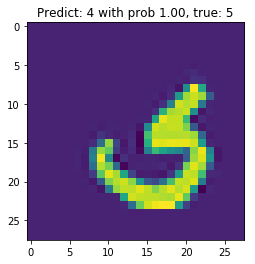

In [26]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

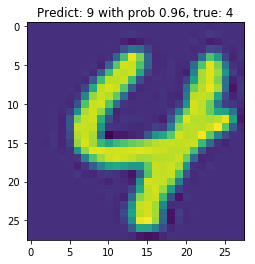

In [30]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

## Let's train on augmented data

In [31]:
# pipeline for train
ppl_shift = (mnistset.train.pipeline().
       load(src=src, fmt='ndarray').
       shift_flattened_pic().
       random_rotate(p=1, angle=(-10, 10), preserve_shape=True).
       random_scale(p=1, factor=(.8, 1.2)).
       train_convy(sess))

In [32]:
for i in tqdm(range(1000)):
    ppl_shift.next_batch(100, n_epochs=None)
    ppl_test_shift.next_batch(100, n_epochs=None)

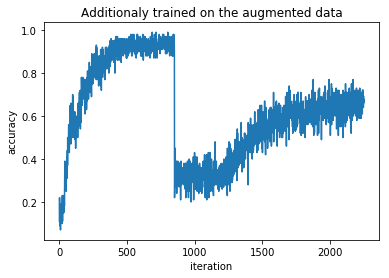

In [36]:
draw_stats(stats, title='Additionaly trained on the augmented data')

In [37]:
pics = []
y_true = []
y_predict = []
probs = []
ppl_results = (mnistset.test.pipeline().
    load(src=src, fmt='ndarray').
    shift_flattened_pic().
    random_rotate(p=1, angle=(-10, 10), preserve_shape=True).
    random_scale(p=1, factor=(.8, 1.2)).
    predict(sess, pics, y_true, y_predict, probs))

In [38]:
ppl_results.next_batch(100, n_epochs=None)

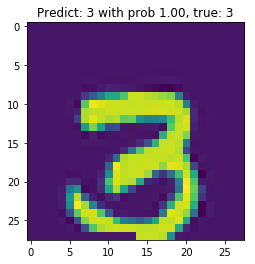

In [40]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

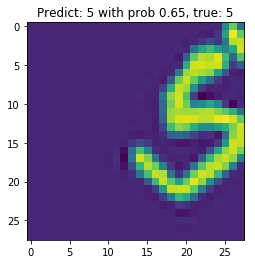

In [44]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

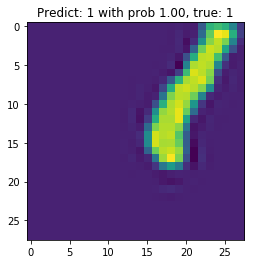

In [48]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

But we still have a space for improvement:

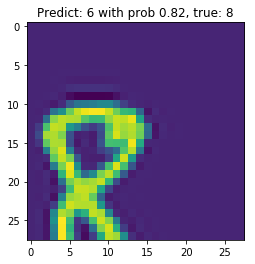

In [52]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

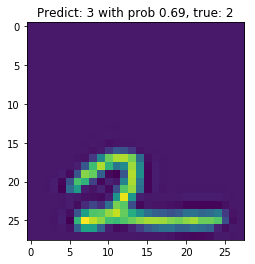

In [53]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

In [54]:
print ('Average accuracy on shifted data: %.2f %%' % (100.0*np.mean(stats[2000:])))

Average accuracy on shifted data: 64.82 %
